# Training U-Net

In [1]:
import time
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from ummon import *


from models.unet import UNet
from utils.water_segmentation import Water
from utils import metrics, dataset_statistics

from matplotlib import pyplot as plt
import numpy as np

In [4]:
from utils.segmentation_analyzer import SegmentationAnalyzer
from utils.segmentation_trainer import SegmentationTrainer, SegmentationLogger
import json

def train(data_loader_trn, data_load_val, opt, model, epochs, path, additional_logger):
       
    loss = nn.BCEWithLogitsLoss()

    # training state
    trs = Trainingstate()

    #Additional logger
    seg_logger = additional_logger

    # optimizer
    loss = nn.BCEWithLogitsLoss()

    with Logger(loglevel=10, logdir='.', log_batch_interval=20) as lg:
    
        # scheduler
        #scd = StepLR_earlystop(opt, trs, model, step_size = step_size, nsteps=n_steps, logger=lg,
        #                       gamma=gamma, patience=patience)
    
        # trainer
        trn = SegmentationTrainer(lg, model, loss, opt, trainingstate=trs, model_filename=path, 
                              combined_training_epochs=0, additional_logger=seg_logger)
    
        # train
        trn.fit(data_loader_trn, epochs=epochs, validation_set=data_loader_val, analyzer=SegmentationAnalyzer)
    
    
        ## evaluate on test set
        trs.load_weights_best_validation_(model)
        ev = SegmentationAnalyzer.evaluate(model, loss, data_loader_val, lg)
        lg.info("Performance on validation set: \nloss={:6.4f} \niou={:.4f} \nacc={:.4f} \nsensitivity={:.4f} \nspecificity={:.4f} \nprecision={:.4f} \nf1={:.4f}".format(
            ev["loss"], ev["iou"],ev["accuracy"], ev["sensitivity"], ev["specificity"], ev["precision"], ev["f1"]))
    
    
    

In [2]:
import matplotlib.pyplot as plt
def visualize_training(data):
    plt.rcParams["figure.figsize"] = (8,5)
    plt.rcParams['axes.xmargin'] = 0
    plt.plot(data["epoch_trn"], data["loss_trn"], label="training loss")
    plt.plot(data["epoch_trn"], data["loss_val"], label="validation loss")
    plt.xlabel('Epochen')
    plt.ylabel('BCE loss')
    plt.legend(loc='best')   
    plt.show()
    print("Minimum validation loss: {0:f} at epoch {1}".format(min(data["loss_val"]), data["loss_val"].index(min(data["loss_val"]))+1))
    print("Minimum training loss: {0:f} at epoch {1}".format(min(data["loss_trn"]), data["loss_trn"].index(min(data["loss_trn"]))+1))
    
    print("Maximum validation IoU: {0:f} at epoch {1}".format(max(data["iou_val"]), data["iou_val"].index(max(data["iou_val"]))+1))
    print("Maximum training IoU: {0:f} at epoch {1}".format(max(data["iou_trn"]), data["iou_trn"].index(max(data["iou_trn"]))+1))

# Training on "Tampere" Dataset only
### Configuration

In [6]:
batch_size = 4
identifier = 'U-Net_Tamp_RMS_lr_e-4'
directory = "../data/training_states/U-Net"
path = os.path.join(directory,identifier)
epochs = 60
lr = 1e-4
weight_decay = 1e-5
momentum = 0

In [44]:
# model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet(3,1,bilinear=False).to(device)

#optimizer
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
logger = SegmentationLogger(["epoch", "loss", "lr", "accuracy", "iou", "sensitivity", "specificity", "precision", "f1"])

### Dataset ###

In [45]:
# Get precalculated mean and standard deviation
mean, std = dataset_statistics.TAMP_OPEN_DOCK

# Transformation to normalize and unnormalize input images
norm = transforms.Normalize(mean, std)
inv_norm = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std])

dataset = Water('../data/WaterDataset', data_list_tamp=['open','dock'], data_list_misc=[],
                    data_constance = False, transforms=norm, img_size=(600,400))
dataset_val = Water('../data/WaterDataset', data_list_tamp=['channel'], data_list_misc=[],
                    data_constance = False, transforms=norm, img_size=(600,400))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=4)

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

print(f'{len(dataset)} images in training dataset')
print(f'{len(dataset_val)} images in validation dataset')

400 images in training dataset
200 images in validation dataset


### Training ###

In [46]:
#train(data_loader, data_loader_val, optimizer, model, epochs, path, additional_logger = logger)
#logger.save_results(path + "_learning_log.json")

[System]
Host                ios-System-Product-Name
Platform            Linux-5.11.0-34-generic-x86_64-with-glibc2.10
CUDA                10.1
CuDNN               7603
Python              ['3.8.8 (default, Apr 13 2021, 19:58:26) ', '[GCC 7.3.0]']
Numpy               1.19.2
Torch               1.8.1
Torchvision         0.9.1
ummon               3.8.0
 
 
[Trainer]
utils.segmentation_trainer.SegmentationTrainer
 
[Model]
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

Epoch: 5 - 00040/00100 - Loss: 0.03963. [ 26 s]
Epoch: 5 - 00060/00100 - Loss: 0.04520. [ 39 s]
Epoch: 5 - 00080/00100 - Loss: 0.10243. [ 52 s]
Epoch: 5 - 00100/00100 - Loss: 0.02983. [ 65 s]
Epoch: 5 - loss(trn/val):0.04851/0.15041, acc(val):95.08%, lr=0.00010. [65s] @6 samples/s 
Epoch: 6 - 00020/00100 - Loss: 0.04551. [ 13 s]
Epoch: 6 - 00040/00100 - Loss: 0.03921. [ 26 s]
Epoch: 6 - 00060/00100 - Loss: 0.05365. [ 39 s]
Epoch: 6 - 00080/00100 - Loss: 0.04223. [ 52 s]
Epoch: 6 - 00100/00100 - Loss: 0.03171. [ 65 s]
Epoch: 6 - loss(trn/val):0.03735/0.13752, acc(val):95.77%, lr=0.00010 [BEST]. [65s] @6 samples/s 
Epoch: 7 - 00020/00100 - Loss: 0.02948. [ 13 s]
Epoch: 7 - 00040/00100 - Loss: 0.03641. [ 26 s]
Epoch: 7 - 00060/00100 - Loss: 0.03989. [ 39 s]
Epoch: 7 - 00080/00100 - Loss: 0.03821. [ 52 s]
Epoch: 7 - 00100/00100 - Loss: 0.02632. [ 65 s]
Epoch: 7 - loss(trn/val):0.02913/0.13492, acc(val):95.78%, lr=0.00010 [BEST]. [65s] @6 samples/s 
Epoch: 8 - 00020/00100 - Loss: 0.03304. [

Epoch: 29 - 00100/00100 - Loss: 0.01770. [ 66 s]
Epoch: 29 - loss(trn/val):0.00931/0.14530, acc(val):96.87%, lr=0.00010. [66s] @6 samples/s 
Epoch: 30 - 00020/00100 - Loss: 0.01776. [ 13 s]
Epoch: 30 - 00040/00100 - Loss: 0.01280. [ 26 s]
Epoch: 30 - 00060/00100 - Loss: 0.00804. [ 39 s]
Epoch: 30 - 00080/00100 - Loss: 0.01028. [ 53 s]
Epoch: 30 - 00100/00100 - Loss: 0.01900. [ 66 s]
Epoch: 30 - loss(trn/val):0.01429/0.16096, acc(val):96.50%, lr=0.00010. [66s] @6 samples/s 
Epoch: 31 - 00020/00100 - Loss: 0.00693. [ 13 s]
Epoch: 31 - 00040/00100 - Loss: 0.00594. [ 26 s]
Epoch: 31 - 00060/00100 - Loss: 0.00879. [ 39 s]
Epoch: 31 - 00080/00100 - Loss: 0.01065. [ 53 s]
Epoch: 31 - 00100/00100 - Loss: 0.00883. [ 66 s]
Epoch: 31 - loss(trn/val):0.01050/0.11417, acc(val):97.32%, lr=0.00010 [BEST]. [66s] @6 samples/s 
Epoch: 32 - 00020/00100 - Loss: 0.01963. [ 13 s]
Epoch: 32 - 00040/00100 - Loss: 0.00512. [ 26 s]
Epoch: 32 - 00060/00100 - Loss: 0.01369. [ 39 s]
Epoch: 32 - 00080/00100 - Loss:

Epoch: 54 - 00020/00100 - Loss: 0.00687. [ 13 s]
Epoch: 54 - 00040/00100 - Loss: 0.00631. [ 26 s]
Epoch: 54 - 00060/00100 - Loss: 0.00508. [ 39 s]
Epoch: 54 - 00080/00100 - Loss: 0.00866. [ 53 s]
Epoch: 54 - 00100/00100 - Loss: 0.01525. [ 66 s]
Epoch: 54 - loss(trn/val):0.00789/0.15437, acc(val):96.75%, lr=0.00010. [66s] @6 samples/s 
Epoch: 55 - 00020/00100 - Loss: 0.02421. [ 13 s]
Epoch: 55 - 00040/00100 - Loss: 0.00701. [ 26 s]
Epoch: 55 - 00060/00100 - Loss: 0.00643. [ 39 s]
Epoch: 55 - 00080/00100 - Loss: 0.00819. [ 53 s]
Epoch: 55 - 00100/00100 - Loss: 0.02448. [ 66 s]
Epoch: 55 - loss(trn/val):0.01051/0.12101, acc(val):96.86%, lr=0.00010. [66s] @6 samples/s 
Epoch: 56 - 00020/00100 - Loss: 0.00437. [ 13 s]
Epoch: 56 - 00040/00100 - Loss: 0.00404. [ 26 s]
Epoch: 56 - 00060/00100 - Loss: 0.00589. [ 39 s]
Epoch: 56 - 00080/00100 - Loss: 0.00702. [ 53 s]
Epoch: 56 - 00100/00100 - Loss: 0.00460. [ 66 s]
Epoch: 56 - loss(trn/val):0.00745/0.15543, acc(val):96.93%, lr=0.00010. [66s] @6 

#### Result: RMS | lr: 0.0001 | wd: 0.00001 | momentum: 0 |

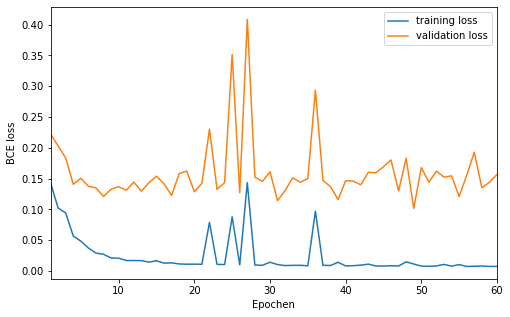

Minimum validation loss: 0.101570 at epoch 49
Minimum training loss: 0.007446 at epoch 56
Maximum validation IoU: 0.949717 at epoch 31
Maximum training IoU: 0.993081 at epoch 56


In [7]:
data = json.load(open(directory +"/U-Net_Tamp_RMS_lr_e-4" + "_learning_log.json"))
visualize_training(data)

# Training on "Misc" Dataset only
### Configuration

In [66]:
batch_size = 4
identifier = 'U-Net_Misc_RMS_lr_e-4'
directory = "../data/training_states/U-Net"
path = os.path.join(directory,identifier)
epochs = 60
lr = 1e-4
weight_decay = 1e-5
momentum = 0

In [4]:
# model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet(3,1,bilinear=False).to(device)

#optimizer
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
logger = SegmentationLogger(["epoch", "loss", "lr", "accuracy", "iou", "sensitivity", "specificity", "precision", "f1"])

### Dataset ###

In [5]:
# Get precalculated mean and standard deviation
mean, std = dataset_statistics.MISC_TRAINING

# Transformation to normalize and unnormalize input images
norm = transforms.Normalize(mean, std)
inv_norm = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std])

dataset = Water('../data/WaterDataset', data_list_tamp=[], data_list_misc=['training'],
                    data_constance = False, transforms=norm, img_size=(600,400))
dataset_val = Water('../data/WaterDataset', data_list_tamp=[], data_list_misc=['validation'],
                    data_constance = False, transforms=norm, img_size=(600,400))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=4)

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

print(f'{len(dataset)} images in training dataset')
print(f'{len(dataset_val)} images in validation dataset')

2188 images in training dataset
212 images in validation dataset


### Training ###

In [6]:
train(data_loader, data_loader_val, optimizer, model, epochs, path, logger)
logger.save_results(path + "_learning_log.json")

[System]
Host                ios-System-Product-Name
Platform            Linux-5.11.0-27-generic-x86_64-with-glibc2.10
CUDA                10.1
CuDNN               7603
Python              ['3.8.8 (default, Apr 13 2021, 19:58:26) ', '[GCC 7.3.0]']
Numpy               1.19.2
Torch               1.8.1
Torchvision         0.9.1
ummon               3.8.0
 
 
[Trainer]
utils.segmentation_trainer.SegmentationTrainer
 
[Model]
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

Epoch: 2 - 00020/00547 - Loss: 0.40343. [ 13 s]
Epoch: 2 - 00040/00547 - Loss: 0.39419. [ 26 s]
Epoch: 2 - 00060/00547 - Loss: 0.34955. [ 39 s]
Epoch: 2 - 00080/00547 - Loss: 0.43589. [ 52 s]
Epoch: 2 - 00100/00547 - Loss: 0.42747. [ 65 s]
Epoch: 2 - 00120/00547 - Loss: 0.33820. [ 78 s]
Epoch: 2 - 00140/00547 - Loss: 0.58086. [ 91 s]
Epoch: 2 - 00160/00547 - Loss: 0.32105. [104 s]
Epoch: 2 - 00180/00547 - Loss: 0.42132. [117 s]
Epoch: 2 - 00200/00547 - Loss: 0.52458. [130 s]
Epoch: 2 - 00220/00547 - Loss: 0.36734. [143 s]
Epoch: 2 - 00240/00547 - Loss: 0.38167. [156 s]
Epoch: 2 - 00260/00547 - Loss: 0.35390. [169 s]
Epoch: 2 - 00280/00547 - Loss: 0.38386. [182 s]
Epoch: 2 - 00300/00547 - Loss: 0.49972. [195 s]
Epoch: 2 - 00320/00547 - Loss: 0.37957. [209 s]
Epoch: 2 - 00340/00547 - Loss: 0.37736. [222 s]
Epoch: 2 - 00360/00547 - Loss: 0.53978. [235 s]
Epoch: 2 - 00380/00547 - Loss: 0.27470. [248 s]
Epoch: 2 - 00400/00547 - Loss: 0.36386. [261 s]
Epoch: 2 - 00420/00547 - Loss: 0.42844. 

Epoch: 7 - 00540/00547 - Loss: 0.28239. [354 s]
Epoch: 7 - loss(trn/val):0.32692/0.41644, acc(val):81.48%, lr=0.00010. [358s] @6 samples/s 
Epoch: 8 - 00020/00547 - Loss: 0.31224. [ 13 s]
Epoch: 8 - 00040/00547 - Loss: 0.21949. [ 26 s]
Epoch: 8 - 00060/00547 - Loss: 0.55785. [ 39 s]
Epoch: 8 - 00080/00547 - Loss: 0.28057. [ 52 s]
Epoch: 8 - 00100/00547 - Loss: 0.42822. [ 65 s]
Epoch: 8 - 00120/00547 - Loss: 0.22899. [ 78 s]
Epoch: 8 - 00140/00547 - Loss: 0.42622. [ 91 s]
Epoch: 8 - 00160/00547 - Loss: 0.35980. [105 s]
Epoch: 8 - 00180/00547 - Loss: 0.22792. [118 s]
Epoch: 8 - 00200/00547 - Loss: 0.24920. [131 s]
Epoch: 8 - 00220/00547 - Loss: 0.31761. [144 s]
Epoch: 8 - 00240/00547 - Loss: 0.81540. [157 s]
Epoch: 8 - 00260/00547 - Loss: 0.38684. [170 s]
Epoch: 8 - 00280/00547 - Loss: 0.27159. [183 s]
Epoch: 8 - 00300/00547 - Loss: 0.71510. [196 s]
Epoch: 8 - 00320/00547 - Loss: 0.25600. [210 s]
Epoch: 8 - 00340/00547 - Loss: 0.39082. [223 s]
Epoch: 8 - 00360/00547 - Loss: 0.34946. [236

Epoch: 13 - 00440/00547 - Loss: 0.50715. [288 s]
Epoch: 13 - 00460/00547 - Loss: 0.21533. [301 s]
Epoch: 13 - 00480/00547 - Loss: 0.25468. [315 s]
Epoch: 13 - 00500/00547 - Loss: 0.30372. [328 s]
Epoch: 13 - 00520/00547 - Loss: 0.34419. [341 s]
Epoch: 13 - 00540/00547 - Loss: 0.38949. [354 s]
Epoch: 13 - loss(trn/val):0.28470/0.35596, acc(val):84.01%, lr=0.00010 [BEST]. [359s] @6 samples/s 
Epoch: 14 - 00020/00547 - Loss: 0.31228. [ 13 s]
Epoch: 14 - 00040/00547 - Loss: 0.35678. [ 26 s]
Epoch: 14 - 00060/00547 - Loss: 0.25399. [ 39 s]
Epoch: 14 - 00080/00547 - Loss: 0.28543. [ 52 s]
Epoch: 14 - 00100/00547 - Loss: 0.40667. [ 65 s]
Epoch: 14 - 00120/00547 - Loss: 0.23399. [ 78 s]
Epoch: 14 - 00140/00547 - Loss: 0.22798. [ 91 s]
Epoch: 14 - 00160/00547 - Loss: 0.32911. [105 s]
Epoch: 14 - 00180/00547 - Loss: 0.44536. [118 s]
Epoch: 14 - 00200/00547 - Loss: 0.42318. [131 s]
Epoch: 14 - 00220/00547 - Loss: 0.16653. [144 s]
Epoch: 14 - 00240/00547 - Loss: 0.30621. [157 s]
Epoch: 14 - 00260/

Epoch: 19 - 00320/00547 - Loss: 0.45015. [209 s]
Epoch: 19 - 00340/00547 - Loss: 0.33189. [223 s]
Epoch: 19 - 00360/00547 - Loss: 0.50923. [236 s]
Epoch: 19 - 00380/00547 - Loss: 0.23230. [249 s]
Epoch: 19 - 00400/00547 - Loss: 0.17407. [262 s]
Epoch: 19 - 00420/00547 - Loss: 0.30093. [275 s]
Epoch: 19 - 00440/00547 - Loss: 0.21961. [288 s]
Epoch: 19 - 00460/00547 - Loss: 0.16936. [301 s]
Epoch: 19 - 00480/00547 - Loss: 0.30879. [314 s]
Epoch: 19 - 00500/00547 - Loss: 0.20154. [327 s]
Epoch: 19 - 00520/00547 - Loss: 0.22783. [341 s]
Epoch: 19 - 00540/00547 - Loss: 0.38651. [354 s]
Epoch: 19 - loss(trn/val):0.26534/0.32053, acc(val):86.56%, lr=0.00010 [BEST]. [358s] @6 samples/s 
Epoch: 20 - 00020/00547 - Loss: 0.24162. [ 13 s]
Epoch: 20 - 00040/00547 - Loss: 0.23756. [ 26 s]
Epoch: 20 - 00060/00547 - Loss: 0.11883. [ 39 s]
Epoch: 20 - 00080/00547 - Loss: 0.55343. [ 52 s]
Epoch: 20 - 00100/00547 - Loss: 0.16397. [ 65 s]
Epoch: 20 - 00120/00547 - Loss: 0.45562. [ 78 s]
Epoch: 20 - 00140/

Epoch: 25 - 00200/00547 - Loss: 0.19382. [131 s]
Epoch: 25 - 00220/00547 - Loss: 0.25270. [144 s]
Epoch: 25 - 00240/00547 - Loss: 0.29756. [157 s]
Epoch: 25 - 00260/00547 - Loss: 0.23339. [170 s]
Epoch: 25 - 00280/00547 - Loss: 0.20317. [183 s]
Epoch: 25 - 00300/00547 - Loss: 0.24336. [196 s]
Epoch: 25 - 00320/00547 - Loss: 0.21967. [210 s]
Epoch: 25 - 00340/00547 - Loss: 0.16795. [223 s]
Epoch: 25 - 00360/00547 - Loss: 0.18671. [236 s]
Epoch: 25 - 00380/00547 - Loss: 0.25145. [249 s]
Epoch: 25 - 00400/00547 - Loss: 0.44826. [262 s]
Epoch: 25 - 00420/00547 - Loss: 0.57346. [275 s]
Epoch: 25 - 00440/00547 - Loss: 0.45629. [288 s]
Epoch: 25 - 00460/00547 - Loss: 0.22879. [302 s]
Epoch: 25 - 00480/00547 - Loss: 0.21255. [315 s]
Epoch: 25 - 00500/00547 - Loss: 0.27722. [328 s]
Epoch: 25 - 00520/00547 - Loss: 0.48925. [341 s]
Epoch: 25 - 00540/00547 - Loss: 0.16792. [354 s]
Epoch: 25 - loss(trn/val):0.27158/0.36381, acc(val):84.66%, lr=0.00010. [359s] @6 samples/s 
Epoch: 26 - 00020/00547 -

Epoch: 31 - 00080/00547 - Loss: 0.41165. [ 52 s]
Epoch: 31 - 00100/00547 - Loss: 0.27288. [ 65 s]
Epoch: 31 - 00120/00547 - Loss: 0.20701. [ 78 s]
Epoch: 31 - 00140/00547 - Loss: 0.41342. [ 92 s]
Epoch: 31 - 00160/00547 - Loss: 0.16030. [105 s]
Epoch: 31 - 00180/00547 - Loss: 0.21387. [118 s]
Epoch: 31 - 00200/00547 - Loss: 0.18939. [131 s]
Epoch: 31 - 00220/00547 - Loss: 0.33580. [144 s]
Epoch: 31 - 00240/00547 - Loss: 0.36519. [157 s]
Epoch: 31 - 00260/00547 - Loss: 0.13687. [171 s]
Epoch: 31 - 00280/00547 - Loss: 0.31033. [184 s]
Epoch: 31 - 00300/00547 - Loss: 0.25001. [197 s]
Epoch: 31 - 00320/00547 - Loss: 0.17447. [210 s]
Epoch: 31 - 00340/00547 - Loss: 0.19620. [223 s]
Epoch: 31 - 00360/00547 - Loss: 0.17504. [236 s]
Epoch: 31 - 00380/00547 - Loss: 0.25653. [249 s]
Epoch: 31 - 00400/00547 - Loss: 0.13522. [263 s]
Epoch: 31 - 00420/00547 - Loss: 0.35627. [276 s]
Epoch: 31 - 00440/00547 - Loss: 0.23012. [289 s]
Epoch: 31 - 00460/00547 - Loss: 0.10408. [302 s]
Epoch: 31 - 00480/00

Epoch: 36 - 00540/00547 - Loss: 0.41912. [355 s]
Epoch: 36 - loss(trn/val):0.18673/0.35238, acc(val):85.78%, lr=0.00010. [359s] @6 samples/s 
Epoch: 37 - 00020/00547 - Loss: 0.08415. [ 13 s]
Epoch: 37 - 00040/00547 - Loss: 0.33540. [ 26 s]
Epoch: 37 - 00060/00547 - Loss: 0.12348. [ 39 s]
Epoch: 37 - 00080/00547 - Loss: 0.26807. [ 52 s]
Epoch: 37 - 00100/00547 - Loss: 0.31677. [ 65 s]
Epoch: 37 - 00120/00547 - Loss: 0.14059. [ 79 s]
Epoch: 37 - 00140/00547 - Loss: 0.14893. [ 92 s]
Epoch: 37 - 00160/00547 - Loss: 0.10118. [105 s]
Epoch: 37 - 00180/00547 - Loss: 0.34081. [118 s]
Epoch: 37 - 00200/00547 - Loss: 0.21939. [131 s]
Epoch: 37 - 00220/00547 - Loss: 0.37234. [144 s]
Epoch: 37 - 00240/00547 - Loss: 0.43528. [157 s]
Epoch: 37 - 00260/00547 - Loss: 0.26540. [171 s]
Epoch: 37 - 00280/00547 - Loss: 0.13329. [184 s]
Epoch: 37 - 00300/00547 - Loss: 0.13118. [197 s]
Epoch: 37 - 00320/00547 - Loss: 0.13460. [210 s]
Epoch: 37 - 00340/00547 - Loss: 0.11131. [223 s]
Epoch: 37 - 00360/00547 -

Epoch: 42 - 00420/00547 - Loss: 0.20735. [276 s]
Epoch: 42 - 00440/00547 - Loss: 0.18636. [289 s]
Epoch: 42 - 00460/00547 - Loss: 0.15003. [302 s]
Epoch: 42 - 00480/00547 - Loss: 0.33258. [315 s]
Epoch: 42 - 00500/00547 - Loss: 0.24073. [329 s]
Epoch: 42 - 00520/00547 - Loss: 0.19006. [342 s]
Epoch: 42 - 00540/00547 - Loss: 0.15276. [355 s]
Epoch: 42 - loss(trn/val):0.17907/0.25314, acc(val):89.71%, lr=0.00010 [BEST]. [360s] @6 samples/s 
Epoch: 43 - 00020/00547 - Loss: 0.33185. [ 13 s]
Epoch: 43 - 00040/00547 - Loss: 0.20119. [ 26 s]
Epoch: 43 - 00060/00547 - Loss: 0.22923. [ 39 s]
Epoch: 43 - 00080/00547 - Loss: 0.21119. [ 52 s]
Epoch: 43 - 00100/00547 - Loss: 0.10945. [ 65 s]
Epoch: 43 - 00120/00547 - Loss: 0.07881. [ 79 s]
Epoch: 43 - 00140/00547 - Loss: 0.14416. [ 92 s]
Epoch: 43 - 00160/00547 - Loss: 0.27034. [105 s]
Epoch: 43 - 00180/00547 - Loss: 0.27929. [118 s]
Epoch: 43 - 00200/00547 - Loss: 0.17722. [131 s]
Epoch: 43 - 00220/00547 - Loss: 0.13532. [144 s]
Epoch: 43 - 00240/

Epoch: 48 - 00300/00547 - Loss: 0.11520. [197 s]
Epoch: 48 - 00320/00547 - Loss: 0.14193. [210 s]
Epoch: 48 - 00340/00547 - Loss: 0.12729. [223 s]
Epoch: 48 - 00360/00547 - Loss: 0.16191. [236 s]
Epoch: 48 - 00380/00547 - Loss: 0.09641. [250 s]
Epoch: 48 - 00400/00547 - Loss: 0.16403. [263 s]
Epoch: 48 - 00420/00547 - Loss: 0.07443. [276 s]
Epoch: 48 - 00440/00547 - Loss: 0.18757. [289 s]
Epoch: 48 - 00460/00547 - Loss: 0.23426. [302 s]
Epoch: 48 - 00480/00547 - Loss: 0.15065. [315 s]
Epoch: 48 - 00500/00547 - Loss: 0.19959. [329 s]
Epoch: 48 - 00520/00547 - Loss: 0.07651. [342 s]
Epoch: 48 - 00540/00547 - Loss: 0.13306. [355 s]
Epoch: 48 - loss(trn/val):0.14522/0.28959, acc(val):88.63%, lr=0.00010. [360s] @6 samples/s 
Epoch: 49 - 00020/00547 - Loss: 0.26008. [ 13 s]
Epoch: 49 - 00040/00547 - Loss: 0.15263. [ 26 s]
Epoch: 49 - 00060/00547 - Loss: 0.18847. [ 39 s]
Epoch: 49 - 00080/00547 - Loss: 0.11255. [ 52 s]
Epoch: 49 - 00100/00547 - Loss: 0.13179. [ 66 s]
Epoch: 49 - 00120/00547 -

Epoch: 54 - 00180/00547 - Loss: 0.26194. [118 s]
Epoch: 54 - 00200/00547 - Loss: 0.09168. [131 s]
Epoch: 54 - 00220/00547 - Loss: 0.23601. [144 s]
Epoch: 54 - 00240/00547 - Loss: 0.43524. [158 s]
Epoch: 54 - 00260/00547 - Loss: 0.12275. [171 s]
Epoch: 54 - 00280/00547 - Loss: 0.13219. [184 s]
Epoch: 54 - 00300/00547 - Loss: 0.08519. [197 s]
Epoch: 54 - 00320/00547 - Loss: 0.07589. [210 s]
Epoch: 54 - 00340/00547 - Loss: 0.15834. [223 s]
Epoch: 54 - 00360/00547 - Loss: 0.08697. [237 s]
Epoch: 54 - 00380/00547 - Loss: 0.12872. [250 s]
Epoch: 54 - 00400/00547 - Loss: 0.18979. [263 s]
Epoch: 54 - 00420/00547 - Loss: 0.09644. [276 s]
Epoch: 54 - 00440/00547 - Loss: 0.40936. [289 s]
Epoch: 54 - 00460/00547 - Loss: 0.17382. [302 s]
Epoch: 54 - 00480/00547 - Loss: 0.16052. [316 s]
Epoch: 54 - 00500/00547 - Loss: 0.08554. [329 s]
Epoch: 54 - 00520/00547 - Loss: 0.14188. [342 s]
Epoch: 54 - 00540/00547 - Loss: 0.21209. [355 s]
Epoch: 54 - loss(trn/val):0.17515/0.34279, acc(val):86.47%, lr=0.0001

Epoch: 60 - 00060/00547 - Loss: 0.04126. [ 39 s]
Epoch: 60 - 00080/00547 - Loss: 0.17792. [ 52 s]
Epoch: 60 - 00100/00547 - Loss: 0.04444. [ 65 s]
Epoch: 60 - 00120/00547 - Loss: 0.12410. [ 79 s]
Epoch: 60 - 00140/00547 - Loss: 0.13908. [ 92 s]
Epoch: 60 - 00160/00547 - Loss: 0.05334. [105 s]
Epoch: 60 - 00180/00547 - Loss: 0.27754. [118 s]
Epoch: 60 - 00200/00547 - Loss: 0.13806. [131 s]
Epoch: 60 - 00220/00547 - Loss: 0.33870. [144 s]
Epoch: 60 - 00240/00547 - Loss: 0.08279. [158 s]
Epoch: 60 - 00260/00547 - Loss: 0.13311. [171 s]
Epoch: 60 - 00280/00547 - Loss: 0.09693. [184 s]
Epoch: 60 - 00300/00547 - Loss: 0.09836. [197 s]
Epoch: 60 - 00320/00547 - Loss: 0.12886. [210 s]
Epoch: 60 - 00340/00547 - Loss: 0.09126. [224 s]
Epoch: 60 - 00360/00547 - Loss: 0.07890. [237 s]
Epoch: 60 - 00380/00547 - Loss: 0.07498. [250 s]
Epoch: 60 - 00400/00547 - Loss: 0.12869. [263 s]
Epoch: 60 - 00420/00547 - Loss: 0.65976. [276 s]
Epoch: 60 - 00440/00547 - Loss: 0.10979. [289 s]
Epoch: 60 - 00460/00

#### Result: RMS | lr: 0.0001 | wd: 0.00001 | momentum: 0 |

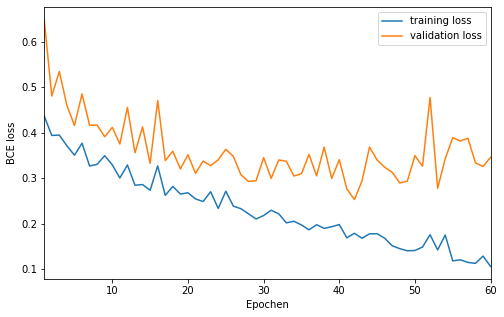

Minimum validation loss: 0.253140 at epoch 42
Minimum training loss: 0.106193 at epoch 60
Maximum validation IoU: 0.731404 at epoch 42
Maximum training IoU: 0.827341 at epoch 60


In [8]:
data = json.load(open(directory + "/U-Net_Misc_RMS_lr_e-4" + "_learning_log.json"))
visualize_training(data)

# Training on "Tampere" and "Misc" Dataset
### Configuration

In [68]:
batch_size = 4
identifier = 'U-Net_Combined_RMS_lr_e-5'
directory = "../data/training_states/U-Net"
path = os.path.join(directory,identifier)
epochs = 60
lr = 1e-5
#betas = (0.9, 0.999)
#eps = 1e-06
weight_decay = 1e-5
momentum = 0

In [13]:
# model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet(3,1,bilinear=False).to(device)

#trs = Trainingstate()
#trs.load_state_('../data/training_states/U-Net_Combined_RMS_lr_e-4.pth.tar')
#trs.load_weights_(model)

#optimizer
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
logger = SegmentationLogger(["epoch", "loss", "lr", "accuracy", "iou", "sensitivity", "specificity", "precision", "f1"])

### Dataset ###

In [14]:
# Get precalculated mean and standard deviation
mean, std = dataset_statistics.TAMP_OPEN_DOCK_MISC_TRN

# Transformation to normalize and unnormalize input images
norm = transforms.Normalize(mean, std)
inv_norm = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std])

dataset = Water('../data/WaterDataset', data_list_tamp=["open", "dock"], data_list_misc=['training'],
                    data_constance = False, transforms=norm, img_size=(600,400))
dataset_val = Water('../data/WaterDataset', data_list_tamp=["channel"], data_list_misc=['validation'],
                    data_constance = False, transforms=norm, img_size=(600,400))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=4)

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

print(f'{len(dataset)} images in training dataset')
print(f'{len(dataset_val)} images in validation dataset')

2588 images in training dataset
412 images in validation dataset


### Training ###

In [16]:
#train(data_loader, data_loader_val, optimizer, model, epochs, path, logger)
#logger.save_results(path + "_learning_log.json")

[System]
Host                ios-System-Product-Name
Platform            Linux-5.11.0-34-generic-x86_64-with-glibc2.10
CUDA                10.1
CuDNN               7603
Python              ['3.8.8 (default, Apr 13 2021, 19:58:26) ', '[GCC 7.3.0]']
Numpy               1.19.2
Torch               1.8.1
Torchvision         0.9.1
ummon               3.8.0
 
 
[Trainer]
utils.segmentation_trainer.SegmentationTrainer
 
[Model]
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

Epoch: 1 - 00600/00647 - Loss: 0.30962. [394 s]
Epoch: 1 - 00620/00647 - Loss: 0.33110. [407 s]
Epoch: 1 - 00640/00647 - Loss: 0.39929. [420 s]
Epoch: 1 - loss(trn/val):0.38464/0.37841, acc(val):82.31%, lr=0.00001 [BEST]. [425s] @6 samples/s 
Epoch: 2 - 00020/00647 - Loss: 0.39904. [ 13 s]
Epoch: 2 - 00040/00647 - Loss: 0.35761. [ 26 s]
Epoch: 2 - 00060/00647 - Loss: 0.46990. [ 39 s]
Epoch: 2 - 00080/00647 - Loss: 0.40888. [ 52 s]
Epoch: 2 - 00100/00647 - Loss: 0.71318. [ 65 s]
Epoch: 2 - 00120/00647 - Loss: 0.37096. [ 79 s]
Epoch: 2 - 00140/00647 - Loss: 0.37226. [ 92 s]
Epoch: 2 - 00160/00647 - Loss: 0.39651. [105 s]
Epoch: 2 - 00180/00647 - Loss: 0.34488. [118 s]
Epoch: 2 - 00200/00647 - Loss: 0.31401. [131 s]
Epoch: 2 - 00220/00647 - Loss: 0.48263. [144 s]
Epoch: 2 - 00240/00647 - Loss: 0.35318. [158 s]
Epoch: 2 - 00260/00647 - Loss: 0.45245. [171 s]
Epoch: 2 - 00280/00647 - Loss: 0.30773. [184 s]
Epoch: 2 - 00300/00647 - Loss: 0.53545. [197 s]
Epoch: 2 - 00320/00647 - Loss: 0.5936

Epoch: 6 - 00620/00647 - Loss: 0.21346. [408 s]
Epoch: 6 - 00640/00647 - Loss: 0.24685. [421 s]
Epoch: 6 - loss(trn/val):0.27837/0.24955, acc(val):90.19%, lr=0.00001 [BEST]. [426s] @6 samples/s 
Epoch: 7 - 00020/00647 - Loss: 0.17143. [ 13 s]
Epoch: 7 - 00040/00647 - Loss: 0.23600. [ 26 s]
Epoch: 7 - 00060/00647 - Loss: 0.27636. [ 39 s]
Epoch: 7 - 00080/00647 - Loss: 0.23808. [ 52 s]
Epoch: 7 - 00100/00647 - Loss: 0.28465. [ 65 s]
Epoch: 7 - 00120/00647 - Loss: 0.40647. [ 79 s]
Epoch: 7 - 00140/00647 - Loss: 0.20534. [ 92 s]
Epoch: 7 - 00160/00647 - Loss: 0.31914. [105 s]
Epoch: 7 - 00180/00647 - Loss: 0.31858. [118 s]
Epoch: 7 - 00200/00647 - Loss: 0.32431. [131 s]
Epoch: 7 - 00220/00647 - Loss: 0.43419. [145 s]
Epoch: 7 - 00240/00647 - Loss: 0.28528. [158 s]
Epoch: 7 - 00260/00647 - Loss: 0.23210. [171 s]
Epoch: 7 - 00280/00647 - Loss: 0.29150. [184 s]
Epoch: 7 - 00300/00647 - Loss: 0.32155. [197 s]
Epoch: 7 - 00320/00647 - Loss: 0.24947. [210 s]
Epoch: 7 - 00340/00647 - Loss: 0.3353

Epoch: 11 - 00620/00647 - Loss: 0.22521. [408 s]
Epoch: 11 - 00640/00647 - Loss: 0.58383. [422 s]
Epoch: 11 - loss(trn/val):0.22383/0.22480, acc(val):90.67%, lr=0.00001 [BEST]. [426s] @6 samples/s 
Epoch: 12 - 00020/00647 - Loss: 0.36968. [ 13 s]
Epoch: 12 - 00040/00647 - Loss: 0.18483. [ 26 s]
Epoch: 12 - 00060/00647 - Loss: 0.31233. [ 39 s]
Epoch: 12 - 00080/00647 - Loss: 0.22240. [ 52 s]
Epoch: 12 - 00100/00647 - Loss: 0.22958. [ 65 s]
Epoch: 12 - 00120/00647 - Loss: 0.13740. [ 78 s]
Epoch: 12 - 00140/00647 - Loss: 0.14930. [ 92 s]
Epoch: 12 - 00160/00647 - Loss: 0.32348. [105 s]
Epoch: 12 - 00180/00647 - Loss: 0.22077. [118 s]
Epoch: 12 - 00200/00647 - Loss: 0.21602. [131 s]
Epoch: 12 - 00220/00647 - Loss: 0.26228. [144 s]
Epoch: 12 - 00240/00647 - Loss: 0.14915. [158 s]
Epoch: 12 - 00260/00647 - Loss: 0.18611. [171 s]
Epoch: 12 - 00280/00647 - Loss: 0.26121. [184 s]
Epoch: 12 - 00300/00647 - Loss: 0.22275. [197 s]
Epoch: 12 - 00320/00647 - Loss: 0.53793. [210 s]
Epoch: 12 - 00340/

Epoch: 16 - 00580/00647 - Loss: 0.11998. [382 s]
Epoch: 16 - 00600/00647 - Loss: 0.17009. [395 s]
Epoch: 16 - 00620/00647 - Loss: 0.25040. [408 s]
Epoch: 16 - 00640/00647 - Loss: 0.27608. [422 s]
Epoch: 16 - loss(trn/val):0.21371/0.21741, acc(val):91.26%, lr=0.00001. [426s] @6 samples/s 
Epoch: 17 - 00020/00647 - Loss: 0.15667. [ 13 s]
Epoch: 17 - 00040/00647 - Loss: 0.14450. [ 26 s]
Epoch: 17 - 00060/00647 - Loss: 0.29584. [ 39 s]
Epoch: 17 - 00080/00647 - Loss: 0.31804. [ 52 s]
Epoch: 17 - 00100/00647 - Loss: 0.36464. [ 66 s]
Epoch: 17 - 00120/00647 - Loss: 0.19275. [ 79 s]
Epoch: 17 - 00140/00647 - Loss: 0.14918. [ 92 s]
Epoch: 17 - 00160/00647 - Loss: 0.16704. [105 s]
Epoch: 17 - 00180/00647 - Loss: 0.16266. [118 s]
Epoch: 17 - 00200/00647 - Loss: 0.28909. [131 s]
Epoch: 17 - 00220/00647 - Loss: 0.28529. [145 s]
Epoch: 17 - 00240/00647 - Loss: 0.12649. [158 s]
Epoch: 17 - 00260/00647 - Loss: 0.13322. [171 s]
Epoch: 17 - 00280/00647 - Loss: 0.13247. [184 s]
Epoch: 17 - 00300/00647 -

Epoch: 21 - 00540/00647 - Loss: 0.21667. [356 s]
Epoch: 21 - 00560/00647 - Loss: 0.17294. [369 s]
Epoch: 21 - 00580/00647 - Loss: 0.16828. [382 s]
Epoch: 21 - 00600/00647 - Loss: 0.09523. [395 s]
Epoch: 21 - 00620/00647 - Loss: 0.12781. [408 s]
Epoch: 21 - 00640/00647 - Loss: 0.23734. [422 s]
Epoch: 21 - loss(trn/val):0.17815/0.19978, acc(val):91.90%, lr=0.00001 [BEST]. [426s] @6 samples/s 
Epoch: 22 - 00020/00647 - Loss: 0.27644. [ 13 s]
Epoch: 22 - 00040/00647 - Loss: 0.13989. [ 26 s]
Epoch: 22 - 00060/00647 - Loss: 0.11676. [ 39 s]
Epoch: 22 - 00080/00647 - Loss: 0.14435. [ 52 s]
Epoch: 22 - 00100/00647 - Loss: 0.21519. [ 65 s]
Epoch: 22 - 00120/00647 - Loss: 0.25371. [ 79 s]
Epoch: 22 - 00140/00647 - Loss: 0.11765. [ 92 s]
Epoch: 22 - 00160/00647 - Loss: 0.27240. [105 s]
Epoch: 22 - 00180/00647 - Loss: 0.14380. [118 s]
Epoch: 22 - 00200/00647 - Loss: 0.18983. [131 s]
Epoch: 22 - 00220/00647 - Loss: 0.20831. [145 s]
Epoch: 22 - 00240/00647 - Loss: 0.14501. [158 s]
Epoch: 22 - 00260/

Epoch: 26 - 00500/00647 - Loss: 0.08350. [329 s]
Epoch: 26 - 00520/00647 - Loss: 0.12997. [342 s]
Epoch: 26 - 00540/00647 - Loss: 0.14532. [356 s]
Epoch: 26 - 00560/00647 - Loss: 0.17604. [369 s]
Epoch: 26 - 00580/00647 - Loss: 0.15073. [382 s]
Epoch: 26 - 00600/00647 - Loss: 0.10267. [395 s]
Epoch: 26 - 00620/00647 - Loss: 0.12143. [408 s]
Epoch: 26 - 00640/00647 - Loss: 0.14137. [422 s]
Epoch: 26 - loss(trn/val):0.14789/0.20818, acc(val):91.49%, lr=0.00001. [426s] @6 samples/s 
Epoch: 27 - 00020/00647 - Loss: 0.16557. [ 13 s]
Epoch: 27 - 00040/00647 - Loss: 0.16139. [ 26 s]
Epoch: 27 - 00060/00647 - Loss: 0.08163. [ 39 s]
Epoch: 27 - 00080/00647 - Loss: 0.12371. [ 52 s]
Epoch: 27 - 00100/00647 - Loss: 0.29127. [ 66 s]
Epoch: 27 - 00120/00647 - Loss: 0.14685. [ 79 s]
Epoch: 27 - 00140/00647 - Loss: 0.09400. [ 92 s]
Epoch: 27 - 00160/00647 - Loss: 0.23462. [105 s]
Epoch: 27 - 00180/00647 - Loss: 0.11953. [118 s]
Epoch: 27 - 00200/00647 - Loss: 0.11615. [131 s]
Epoch: 27 - 00220/00647 -

Epoch: 31 - 00460/00647 - Loss: 0.28130. [303 s]
Epoch: 31 - 00480/00647 - Loss: 0.14981. [316 s]
Epoch: 31 - 00500/00647 - Loss: 0.17125. [329 s]
Epoch: 31 - 00520/00647 - Loss: 0.11218. [343 s]
Epoch: 31 - 00540/00647 - Loss: 0.15105. [356 s]
Epoch: 31 - 00560/00647 - Loss: 0.06822. [369 s]
Epoch: 31 - 00580/00647 - Loss: 0.13503. [382 s]
Epoch: 31 - 00600/00647 - Loss: 0.11181. [395 s]
Epoch: 31 - 00620/00647 - Loss: 0.15291. [409 s]
Epoch: 31 - 00640/00647 - Loss: 0.10752. [422 s]
Epoch: 31 - loss(trn/val):0.14308/0.28433, acc(val):89.88%, lr=0.00001. [426s] @6 samples/s 
Epoch: 32 - 00020/00647 - Loss: 0.09457. [ 13 s]
Epoch: 32 - 00040/00647 - Loss: 0.14403. [ 26 s]
Epoch: 32 - 00060/00647 - Loss: 0.11140. [ 39 s]
Epoch: 32 - 00080/00647 - Loss: 0.08502. [ 52 s]
Epoch: 32 - 00100/00647 - Loss: 0.10428. [ 66 s]
Epoch: 32 - 00120/00647 - Loss: 0.15957. [ 79 s]
Epoch: 32 - 00140/00647 - Loss: 0.22128. [ 92 s]
Epoch: 32 - 00160/00647 - Loss: 0.06825. [105 s]
Epoch: 32 - 00180/00647 -

Epoch: 36 - 00420/00647 - Loss: 0.03831. [277 s]
Epoch: 36 - 00440/00647 - Loss: 0.14139. [290 s]
Epoch: 36 - 00460/00647 - Loss: 0.09316. [303 s]
Epoch: 36 - 00480/00647 - Loss: 0.11533. [316 s]
Epoch: 36 - 00500/00647 - Loss: 0.03441. [330 s]
Epoch: 36 - 00520/00647 - Loss: 0.10251. [343 s]
Epoch: 36 - 00540/00647 - Loss: 0.30887. [356 s]
Epoch: 36 - 00560/00647 - Loss: 0.08103. [369 s]
Epoch: 36 - 00580/00647 - Loss: 0.19627. [382 s]
Epoch: 36 - 00600/00647 - Loss: 0.13468. [395 s]
Epoch: 36 - 00620/00647 - Loss: 0.06798. [409 s]
Epoch: 36 - 00640/00647 - Loss: 0.10152. [422 s]
Epoch: 36 - loss(trn/val):0.09097/0.21519, acc(val):91.84%, lr=0.00001. [427s] @6 samples/s 
Epoch: 37 - 00020/00647 - Loss: 0.07671. [ 13 s]
Epoch: 37 - 00040/00647 - Loss: 0.08921. [ 26 s]
Epoch: 37 - 00060/00647 - Loss: 0.04451. [ 39 s]
Epoch: 37 - 00080/00647 - Loss: 0.10890. [ 52 s]
Epoch: 37 - 00100/00647 - Loss: 0.07451. [ 66 s]
Epoch: 37 - 00120/00647 - Loss: 0.08924. [ 79 s]
Epoch: 37 - 00140/00647 -

Epoch: 41 - 00380/00647 - Loss: 0.06965. [250 s]
Epoch: 41 - 00400/00647 - Loss: 0.09025. [264 s]
Epoch: 41 - 00420/00647 - Loss: 0.16323. [277 s]
Epoch: 41 - 00440/00647 - Loss: 0.03854. [290 s]
Epoch: 41 - 00460/00647 - Loss: 0.10350. [303 s]
Epoch: 41 - 00480/00647 - Loss: 0.07327. [316 s]
Epoch: 41 - 00500/00647 - Loss: 0.15148. [330 s]
Epoch: 41 - 00520/00647 - Loss: 0.07582. [343 s]
Epoch: 41 - 00540/00647 - Loss: 0.05630. [356 s]
Epoch: 41 - 00560/00647 - Loss: 0.16039. [369 s]
Epoch: 41 - 00580/00647 - Loss: 0.03838. [382 s]
Epoch: 41 - 00600/00647 - Loss: 0.04825. [396 s]
Epoch: 41 - 00620/00647 - Loss: 0.07486. [409 s]
Epoch: 41 - 00640/00647 - Loss: 0.10193. [422 s]
Epoch: 41 - loss(trn/val):0.07076/0.22545, acc(val):91.82%, lr=0.00001. [427s] @6 samples/s 
Epoch: 42 - 00020/00647 - Loss: 0.07088. [ 13 s]
Epoch: 42 - 00040/00647 - Loss: 0.04195. [ 26 s]
Epoch: 42 - 00060/00647 - Loss: 0.11258. [ 39 s]
Epoch: 42 - 00080/00647 - Loss: 0.07674. [ 52 s]
Epoch: 42 - 00100/00647 -

Epoch: 46 - 00340/00647 - Loss: 0.04133. [224 s]
Epoch: 46 - 00360/00647 - Loss: 0.06225. [237 s]
Epoch: 46 - 00380/00647 - Loss: 0.05939. [250 s]
Epoch: 46 - 00400/00647 - Loss: 0.08625. [264 s]
Epoch: 46 - 00420/00647 - Loss: 0.05810. [277 s]
Epoch: 46 - 00440/00647 - Loss: 0.06903. [290 s]
Epoch: 46 - 00460/00647 - Loss: 0.03335. [303 s]
Epoch: 46 - 00480/00647 - Loss: 0.06588. [316 s]
Epoch: 46 - 00500/00647 - Loss: 0.05232. [330 s]
Epoch: 46 - 00520/00647 - Loss: 0.03932. [343 s]
Epoch: 46 - 00540/00647 - Loss: 0.05179. [356 s]
Epoch: 46 - 00560/00647 - Loss: 0.07214. [369 s]
Epoch: 46 - 00580/00647 - Loss: 0.06806. [383 s]
Epoch: 46 - 00600/00647 - Loss: 0.07569. [396 s]
Epoch: 46 - 00620/00647 - Loss: 0.08773. [409 s]
Epoch: 46 - 00640/00647 - Loss: 0.09323. [422 s]
Epoch: 46 - loss(trn/val):0.06482/0.25326, acc(val):91.51%, lr=0.00001. [427s] @6 samples/s 
Epoch: 47 - 00020/00647 - Loss: 0.05826. [ 13 s]
Epoch: 47 - 00040/00647 - Loss: 0.05717. [ 26 s]
Epoch: 47 - 00060/00647 -

Epoch: 51 - 00300/00647 - Loss: 0.05407. [197 s]
Epoch: 51 - 00320/00647 - Loss: 0.02657. [211 s]
Epoch: 51 - 00340/00647 - Loss: 0.04530. [224 s]
Epoch: 51 - 00360/00647 - Loss: 0.04900. [237 s]
Epoch: 51 - 00380/00647 - Loss: 0.03933. [250 s]
Epoch: 51 - 00400/00647 - Loss: 0.10949. [264 s]
Epoch: 51 - 00420/00647 - Loss: 0.10017. [277 s]
Epoch: 51 - 00440/00647 - Loss: 0.05338. [290 s]
Epoch: 51 - 00460/00647 - Loss: 0.07525. [303 s]
Epoch: 51 - 00480/00647 - Loss: 0.07136. [316 s]
Epoch: 51 - 00500/00647 - Loss: 0.07896. [330 s]
Epoch: 51 - 00520/00647 - Loss: 0.04352. [343 s]
Epoch: 51 - 00540/00647 - Loss: 0.05386. [356 s]
Epoch: 51 - 00560/00647 - Loss: 0.02759. [369 s]
Epoch: 51 - 00580/00647 - Loss: 0.05870. [382 s]
Epoch: 51 - 00600/00647 - Loss: 0.05263. [396 s]
Epoch: 51 - 00620/00647 - Loss: 0.05894. [409 s]
Epoch: 51 - 00640/00647 - Loss: 0.08037. [422 s]
Epoch: 51 - loss(trn/val):0.04561/0.22135, acc(val):92.63%, lr=0.00001. [427s] @6 samples/s 
Epoch: 52 - 00020/00647 -

Epoch: 56 - 00260/00647 - Loss: 0.03686. [171 s]
Epoch: 56 - 00280/00647 - Loss: 0.03136. [184 s]
Epoch: 56 - 00300/00647 - Loss: 0.05367. [198 s]
Epoch: 56 - 00320/00647 - Loss: 0.02948. [211 s]
Epoch: 56 - 00340/00647 - Loss: 0.05037. [224 s]
Epoch: 56 - 00360/00647 - Loss: 0.06480. [237 s]
Epoch: 56 - 00380/00647 - Loss: 0.07085. [250 s]
Epoch: 56 - 00400/00647 - Loss: 0.02607. [264 s]
Epoch: 56 - 00420/00647 - Loss: 0.03690. [277 s]
Epoch: 56 - 00440/00647 - Loss: 0.06333. [290 s]
Epoch: 56 - 00460/00647 - Loss: 0.04246. [303 s]
Epoch: 56 - 00480/00647 - Loss: 0.11431. [317 s]
Epoch: 56 - 00500/00647 - Loss: 0.03016. [330 s]
Epoch: 56 - 00520/00647 - Loss: 0.04408. [343 s]
Epoch: 56 - 00540/00647 - Loss: 0.08980. [356 s]
Epoch: 56 - 00560/00647 - Loss: 0.06454. [369 s]
Epoch: 56 - 00580/00647 - Loss: 0.03882. [383 s]
Epoch: 56 - 00600/00647 - Loss: 0.10483. [396 s]
Epoch: 56 - 00620/00647 - Loss: 0.08838. [409 s]
Epoch: 56 - 00640/00647 - Loss: 0.02551. [422 s]
Epoch: 56 - loss(trn

#### Result: RMS | lr: 0.00001 | wd: 0.00001 | momentum: 0 |

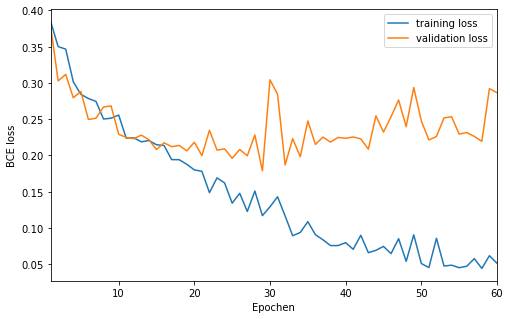

Minimum validation loss: 0.178822 at epoch 29
Minimum training loss: 0.044408 at epoch 58
Maximum validation IoU: 0.821498 at epoch 29
Maximum training IoU: 0.938874 at epoch 53


In [9]:
data = json.load(open(directory +"/U-Net_Combined_RMS_lr_e-5" + "_learning_log.json"))
visualize_training(data)

#### Result: RMS | lr: 0.0001 | wd: 0.00001 | momentum: 0 |

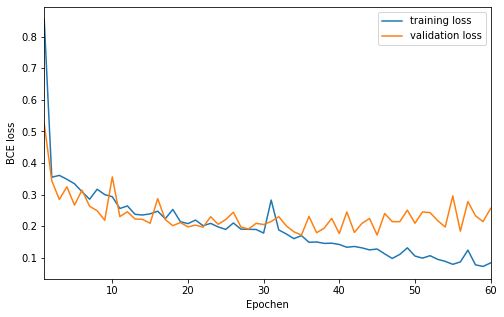

Minimum validation loss: 0.171806 at epoch 35
Minimum training loss: 0.072422 at epoch 59
Maximum validation IoU: 0.827956 at epoch 35
Maximum training IoU: 0.895810 at epoch 59


In [10]:
data = json.load(open(directory +"/U-Net_Combined_RMS_lr_e-4" + "_learning_log.json"))
visualize_training(data)

#### Result: RMS | lr: 0.001 | wd: 0.00001 | momentum: 0 |

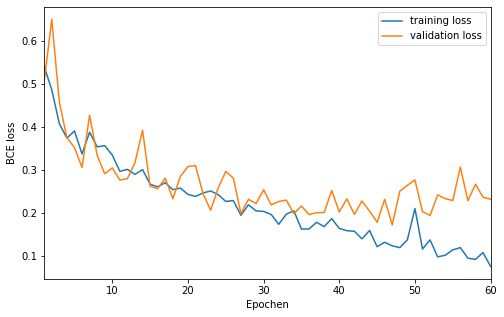

Minimum validation loss: 0.172095 at epoch 47
Minimum training loss: 0.075647 at epoch 60
Maximum validation IoU: 0.818550 at epoch 47
Maximum training IoU: 0.893493 at epoch 60


In [11]:
data = json.load(open(directory +"/U-Net_Combined_RMS_lr_e-3" + "_learning_log.json"))
visualize_training(data)